In [2]:
# plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
import folium
from folium.plugins import HeatMap

# basic
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import pylab
import category_encoders as ce

# preprocessomg
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import NearestNeighbors
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# models
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, ParameterGrid, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# compress warning
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

# Import Data

In [3]:
# main data
train_data_path = './dataset/train.csv'
test_data_path = './dataset/test.csv'

# auxiliary data
mrt_exist_data_path = './dataset/auxiliary-data/sg-mrt-existing-stations.csv'
mrt_planned_data_path = './dataset/auxiliary-data/sg-mrt-planned-stations.csv'
mall_data_path = './dataset/auxiliary-data/sg-shopping-malls.csv'
primary_school_data_path = './dataset/auxiliary-data/sg-primary-schools.csv'
coe_price_data_path = './dataset/auxiliary-data/sg-coe-prices.csv'
stock_price_data_path = './dataset/auxiliary-data/sg-stock-prices.csv'

# Load Data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
test_data['monthly_rent'] = 0
mrt_exist_data = pd.read_csv(mrt_exist_data_path)
mrt_planned_data = pd.read_csv(mrt_planned_data_path)
mall_data = pd.read_csv(mall_data_path)
primary_school_data = pd.read_csv(primary_school_data_path)
coe_price_data = pd.read_csv(coe_price_data_path)
stock_price_data = pd.read_csv(stock_price_data_path)

# 0. Cleaning

1. 新加坡的住宅物业: 二房式灵活组屋（2-room flexi flat）、三房式组屋（3-room flat）、四房式组屋（4-room flat）、五房式组屋（5-room flat）、三代同堂组屋（3Gen flat）、公寓式组屋（Executive flat）

In [4]:
# flat_type
train_data['flat_type'] = train_data['flat_type'].str.replace("-", " ")
test_data['flat_type'] = test_data['flat_type'].str.replace("-", " ")

# monthly_rent
mean = train_data['monthly_rent'].mean()
std = train_data['monthly_rent'].std()
std_multiplier = 3
lower_threshold = mean - std_multiplier * std
upper_threshold = mean + std_multiplier * std
train_data = train_data[(train_data['monthly_rent'] >= lower_threshold) & (train_data['monthly_rent'] <= upper_threshold)]

# mrt_planned
mrt_planned_data['opening_year'].replace('TBA', pd.NA, inplace=True)
mrt_planned_data.dropna(subset=['opening_year'], inplace=True)
# only include those planned within 3 years, due to the policy restriction
mrt_planned_data = mrt_planned_data[(mrt_planned_data['opening_year']).astype(int) < 2029]

train_data.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


# 1. EDA - Main Data


**0.1 General Info**

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59641 entries, 0 to 59999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rent_approval_date   59641 non-null  object 
 1   town                 59641 non-null  object 
 2   block                59641 non-null  object 
 3   street_name          59641 non-null  object 
 4   flat_type            59641 non-null  object 
 5   flat_model           59641 non-null  object 
 6   floor_area_sqm       59641 non-null  float64
 7   furnished            59641 non-null  object 
 8   lease_commence_date  59641 non-null  int64  
 9   latitude             59641 non-null  float64
 10  longitude            59641 non-null  float64
 11  elevation            59641 non-null  float64
 12  subzone              59641 non-null  object 
 13  planning_area        59641 non-null  object 
 14  region               59641 non-null  object 
 15  monthly_rent         59641 non-null  int6

**0.2 Descriptive Statistics**

In [6]:
train_data.describe()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,monthly_rent
count,59641.000000,59641.000000,59641.000000,59641.000000,59641.0,59641.000000
mean,94.380334,1990.816301,1.359713,103.840174,0.0,2574.992036
std,24.051840,12.108747,0.042395,0.071722,0.0,686.784694
min,34.000000,1966.000000,1.270380,103.685228,0.0,450.000000
25%,73.000000,1981.000000,1.331245,103.778405,0.0,2100.000000
50%,93.000000,1988.000000,1.354314,103.845493,0.0,2400.000000
75%,110.000000,2000.000000,1.387165,103.897573,0.0,2950.000000
max,192.000000,2019.000000,1.457071,103.964915,0.0,4700.000000


**0.3 Visualization of General Info**

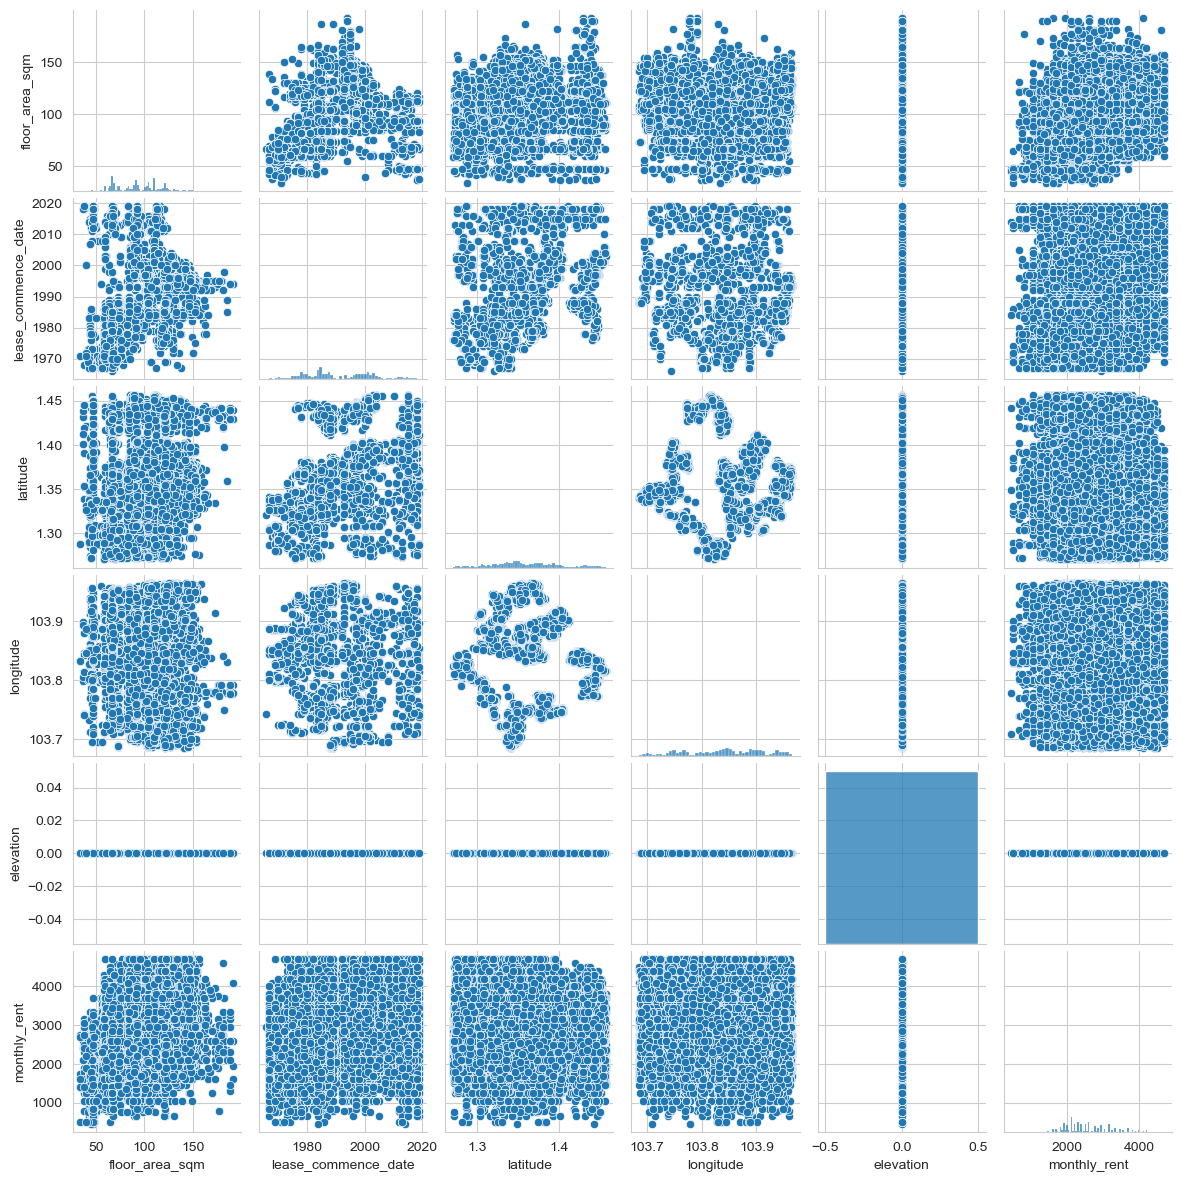

In [7]:
sns.pairplot(train_data,height=2)
plt.show()

**Observations**

There is no null value for any column in the dataset.
The scale of numerical data varies significantly, remember to normalize before analysis
There are natural groups but not clear, further observation required

**0.4 Univariate Analysis - Categorical - town & subarea**

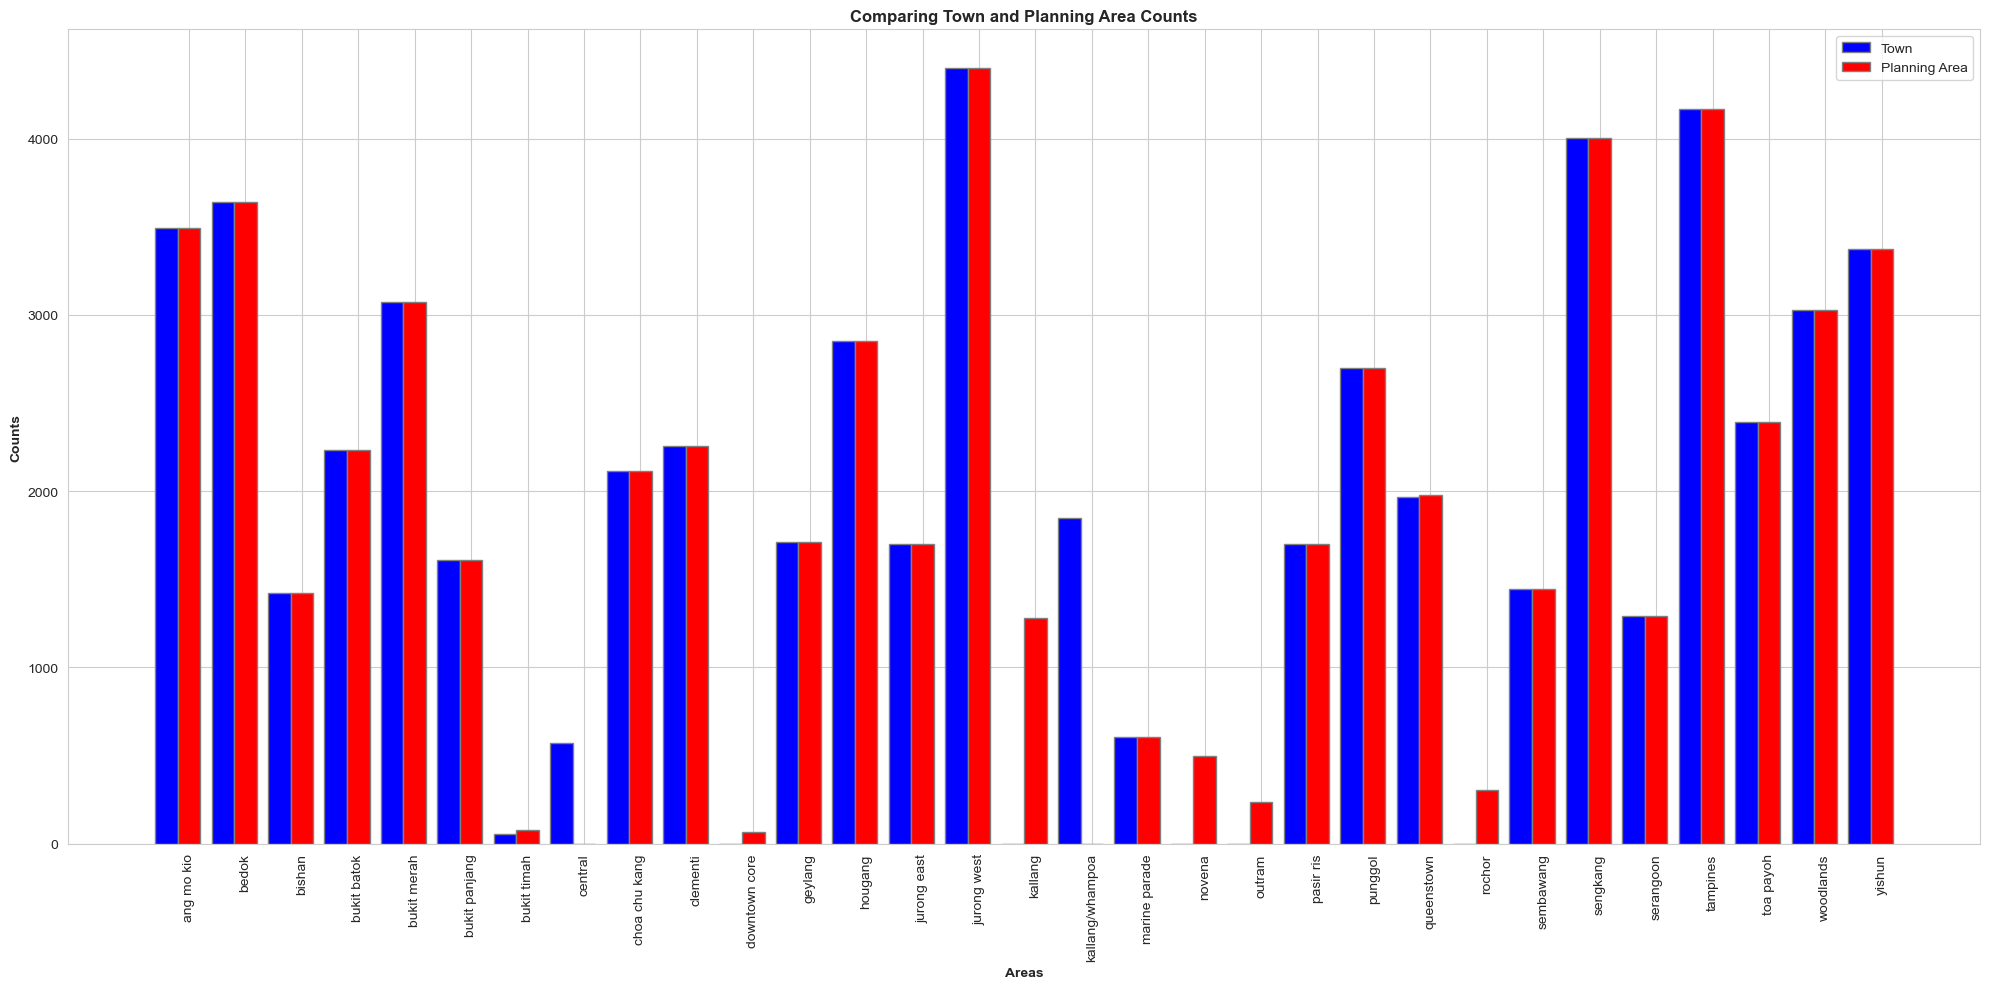

In [8]:
town_counts = train_data['town'].value_counts()
planning_area_counts = train_data['planning_area'].value_counts()



# Merge the two Series into a single DataFrame
combined_df = pd.DataFrame({'Town': town_counts, 'Planning Area': planning_area_counts}).fillna(0)

# Plotting
plt.figure(figsize=(20, 10))

# Width of a bar
width = 0.4

# Positions of bars on x axis
r1 = range(len(combined_df))
r2 = [x + width for x in r1]

# Creating bars
plt.bar(r1, combined_df['Town'], width=width, label='Town', color='blue', edgecolor='grey')
plt.bar(r2, combined_df['Planning Area'], width=width, label='Planning Area', color='red', edgecolor='grey')

# Title & Subtitle
plt.title('Comparing Town and Planning Area Counts', fontweight='bold')

# X axis
plt.xlabel('Areas', fontweight='bold')
plt.xticks([r + width for r in range(len(combined_df))], combined_df.index, rotation=90)

# Y axis
plt.ylabel('Counts', fontweight='bold')

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

**0.5 Univariate Analysis - Categorical - flat_type**

In [9]:
train_data['flat_type'].value_counts()

flat_type
4 room       21754
3 room       18885
5 room       14608
executive     3473
2 room         921
Name: count, dtype: int64

**0.6 Univariate Analysis - Categorical - flat_model**

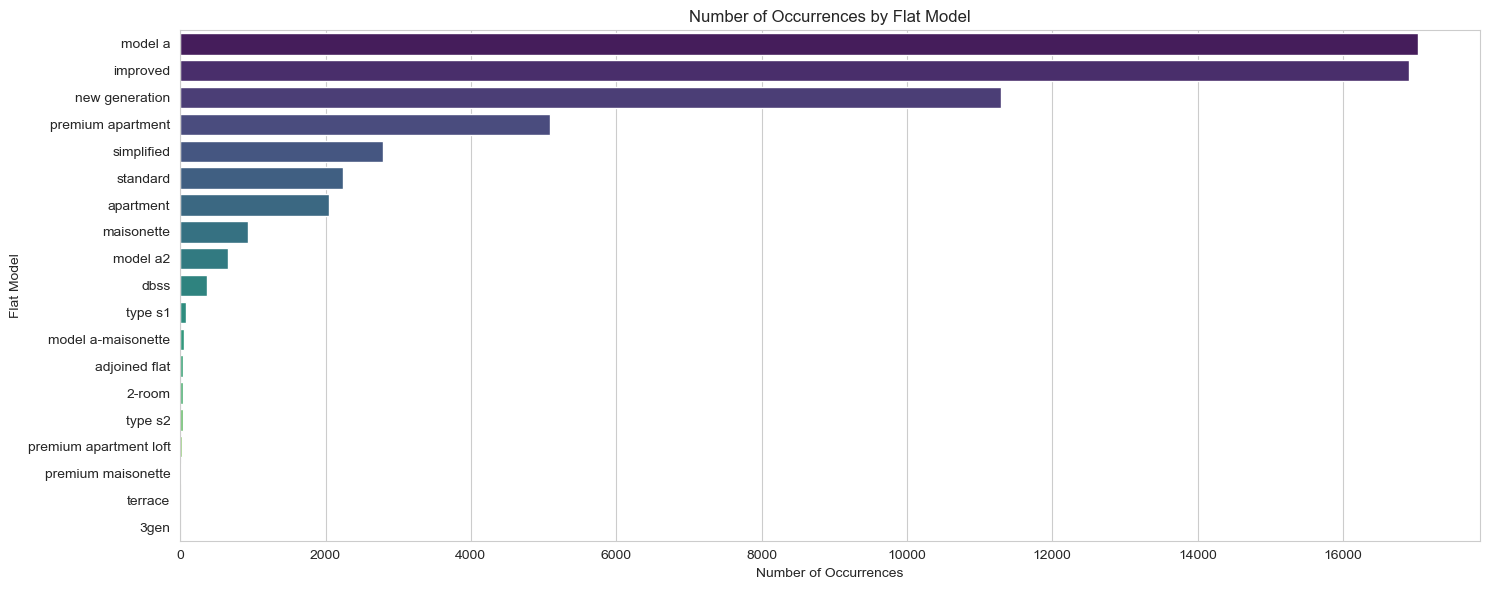

In [10]:
flat_model_counts = train_data['flat_model'].value_counts()

# Plotting
plt.figure(figsize=(15,6))  # Adjust the figure size
sns.barplot(y=flat_model_counts.index, x=flat_model_counts.values, palette='viridis')  # Use y for town names to get a horizontal bar plot

# Add titles and labels
plt.title('Number of Occurrences by Flat Model')
plt.xlabel('Number of Occurrences')
plt.ylabel('Flat Model')

# Display the plot
plt.tight_layout()
plt.show()

**0.7 Univariate Analysis - Categorical - furnished**

In [11]:
train_data['furnished'].value_counts()

furnished
yes    59641
Name: count, dtype: int64

**0.7 Univariate Analysis - Categorical - latitude & longitude**


In [12]:
latitude = train_data['latitude']
longitude = train_data['longitude']

avg_lat, avg_lon = latitude.mean(), longitude.mean()

# Create a base map
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Add the heat map
heat_data = [[lat, lon] for lat, lon in zip(train_data['latitude'], train_data['longitude'])]
HeatMap(heat_data).add_to(m)

# Display the map if NEEDED
# m

**0.8 Univariate Analysis - Categorical - subzone**

In [13]:
train_data['subzone'].value_counts()

subzone
tampines east             2461
bedok north               1643
jurong west central       1490
woodlands east            1318
punggol field             1203
sengkang town centre      1197
tampines west             1094
yishun west               1094
clementi north            1090
rivervale                  917
yunnan                     867
anchorvale                 837
pasir ris drive            824
hong kah                   811
cheng san                  802
hougang west               776
yishun south               720
yishun east                682
fernvale                   681
yew tee                    680
toa payoh central          660
bedok south                652
waterway east              651
kebun bahru                625
macpherson                 621
chong boon                 619
simei                      614
sembawang central          613
marine parade              606
matilda                    605
taman jurong               594
yuhua east                 591


**0.8 Univariate Analysis - Categorical - region**

In [14]:
train_data['region'].value_counts()

region
north-east region    14336
west region          14312
central region       13638
east region           9509
north region          7846
Name: count, dtype: int64

**0.8 Univariate Analysis - Categorical - block**

In [15]:
train_data['block'].value_counts()

block
102     220
34      219
105     203
114     202
108     201
113     199
101     188
109     184
110     182
32      178
112     178
17      178
30      177
22      176
107     176
116     174
115     173
11      172
20      171
28      169
19      169
117     167
130     167
18      167
23      166
21      164
10      162
12      161
13      158
124     157
106     151
211     149
111     146
157     142
33      141
103     141
104     141
210     140
121     140
120     139
304     137
119     136
204     130
122     130
31      127
129     125
419     125
45      123
125     122
128     122
406     122
44      121
24      120
202     119
27      119
123     117
231     116
55      116
26      115
35      115
132     114
53      114
146     114
161     113
118     113
16      113
52      113
126     112
421     112
534     112
50      112
51      112
82      110
303     110
205     109
15      108
214     107
327     106
229     106
306     105
185     105
213     105
142     10

**0.8 Univariate Analysis - Numerical - monthly_rent**

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


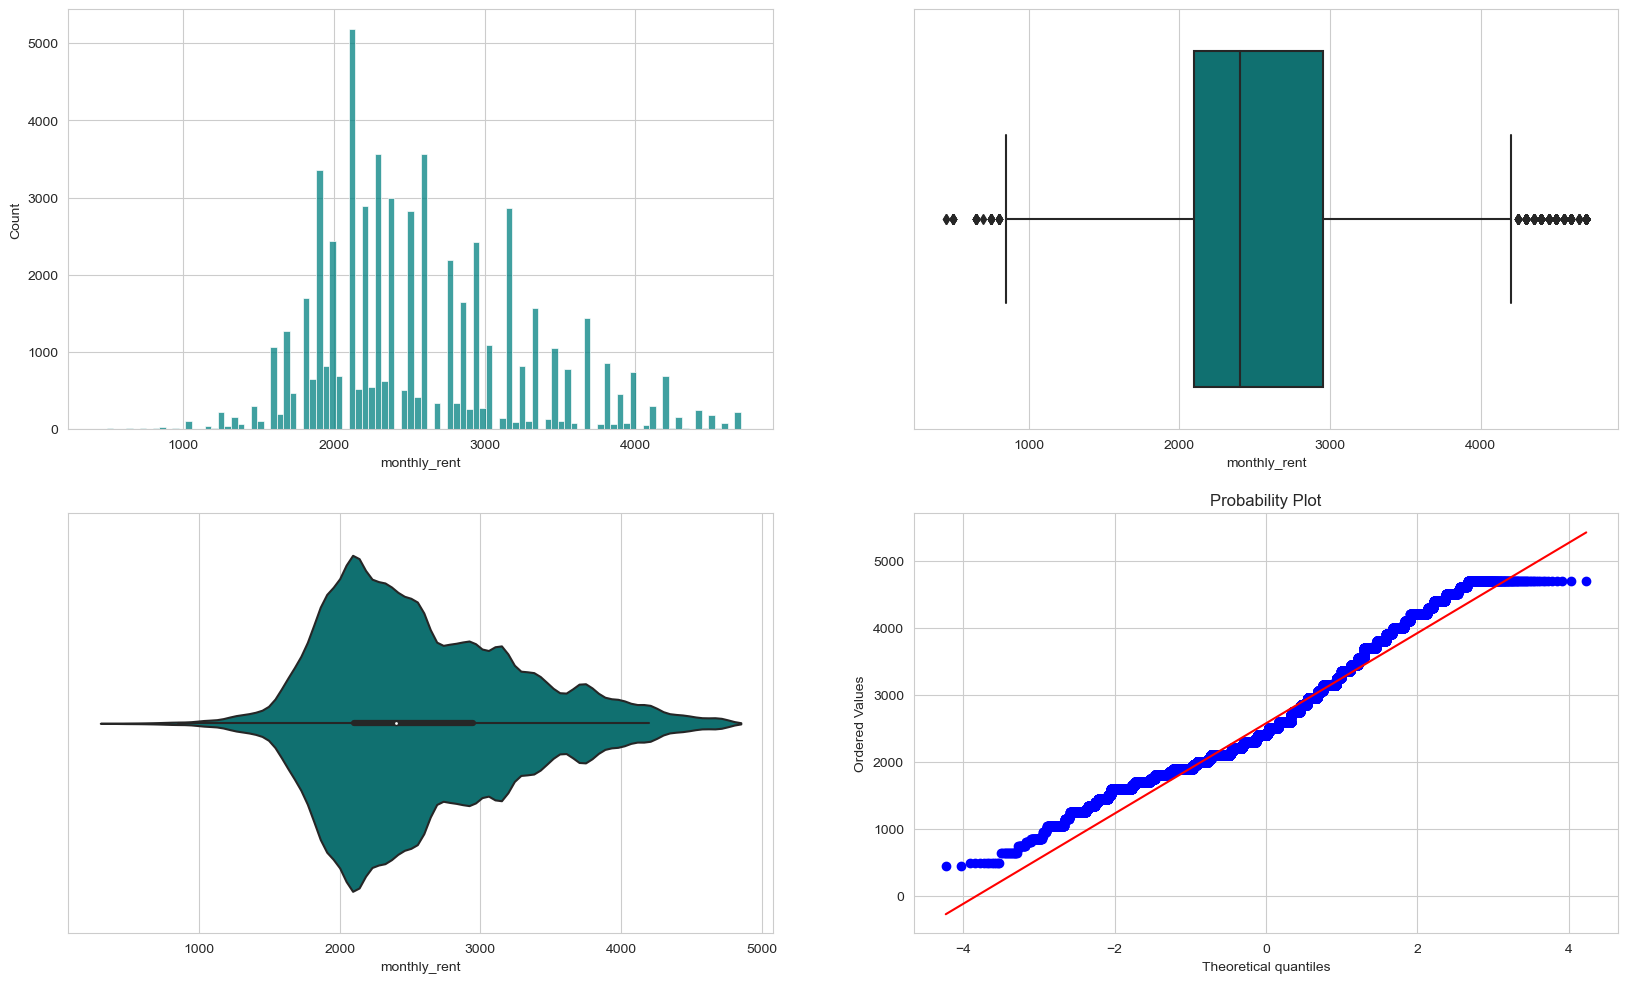

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = train_data['monthly_rent'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = train_data['monthly_rent'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = train_data['monthly_rent'], ax= ax[1, 0], color= 'teal')
ax4 = probplot(train_data['monthly_rent'], plot=pylab)
pylab.show()

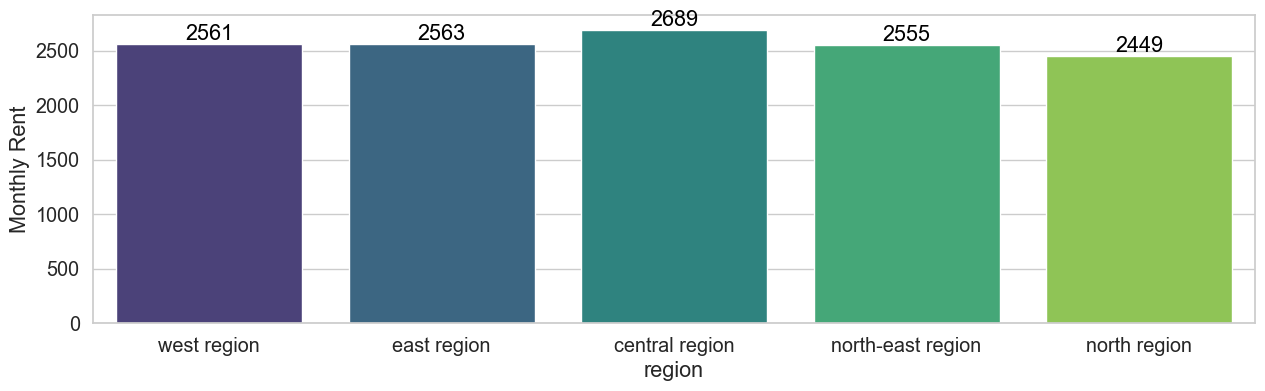

In [17]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=train_data['region'],
                 y=train_data['monthly_rent'],
                 palette='viridis',
                 ci = None)
plt.ylabel('Monthly Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

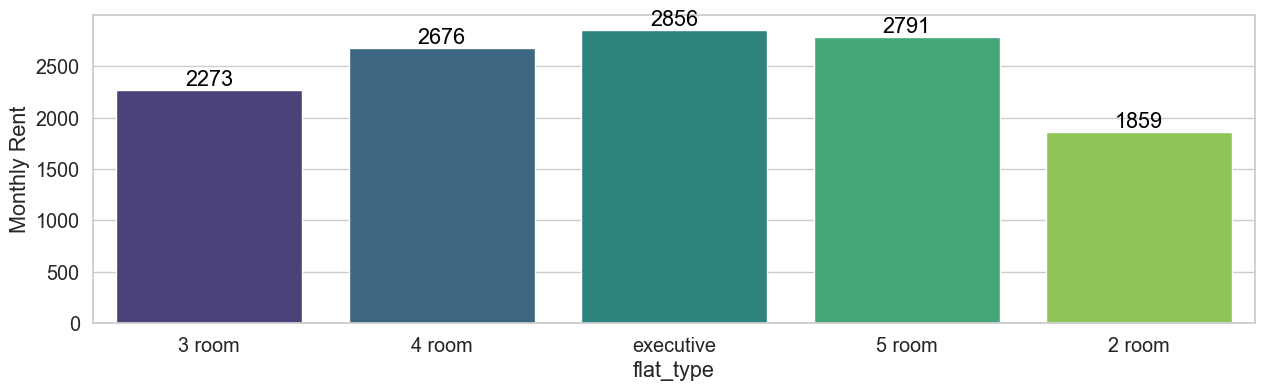

In [18]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=train_data['flat_type'],
                 y=train_data['monthly_rent'],
                 palette='viridis',
                 ci = None)
plt.ylabel('Monthly Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

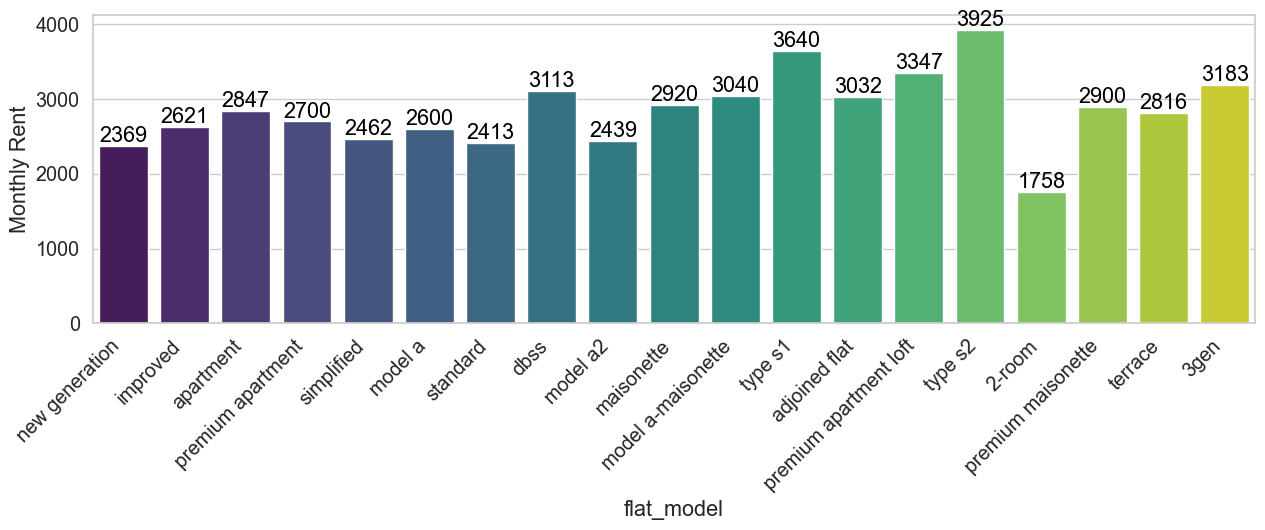

In [19]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=train_data['flat_model'],
                 y=train_data['monthly_rent'],
                 palette='viridis',
                 ci = None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('Monthly Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

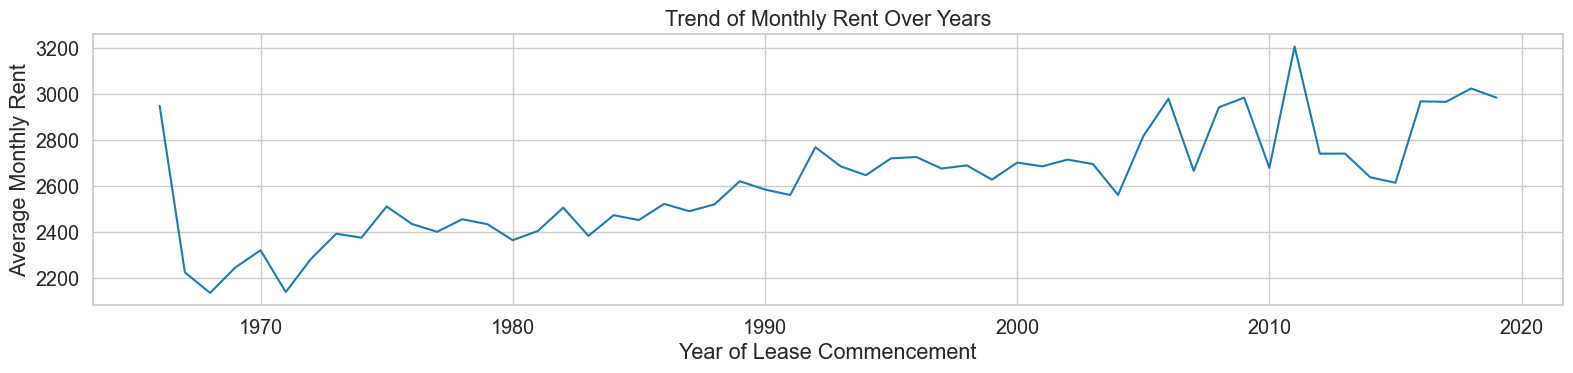

In [20]:
train_data = train_data.sort_values('lease_commence_date')

# Plot
plt.figure(figsize=(16, 4))
sns.lineplot(x='lease_commence_date', y='monthly_rent', data=train_data, ci=None)

plt.title('Trend of Monthly Rent Over Years')
plt.xlabel('Year of Lease Commencement')
plt.ylabel('Average Monthly Rent')
plt.tight_layout()
plt.show()

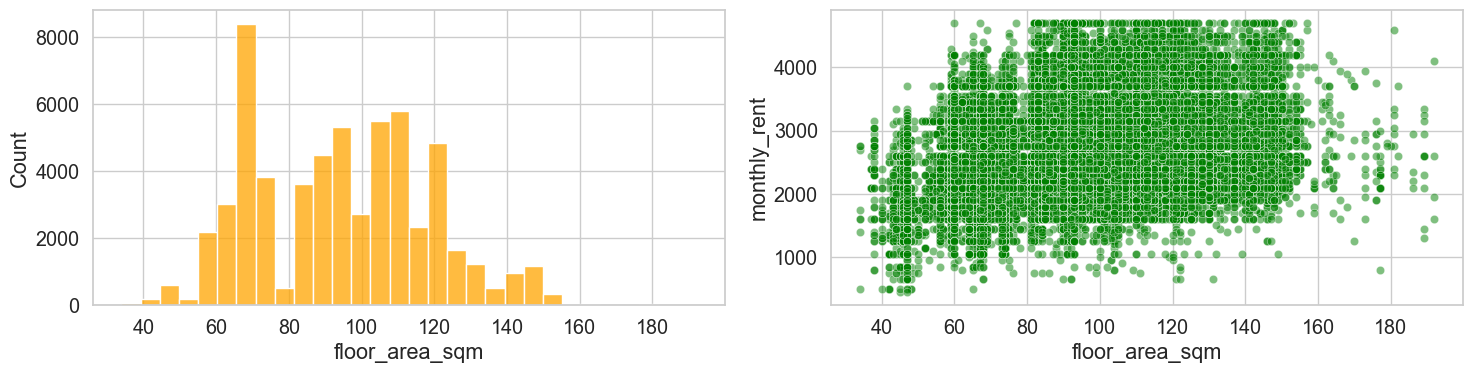

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(train_data['floor_area_sqm'], bins=30, kde=False, color='orange', ax=ax[0])  # Adjust position as desired
sns.scatterplot(x=train_data['floor_area_sqm'], y=train_data['monthly_rent'], ax=ax[1], color='green', alpha=0.5)  # Adjust position as desired

plt.tight_layout()
plt.show()

# 0. EDA - Aux Data

**0.1 coe**
* To register a vehicle, you must first bid for a COE.Category refers to different vehicle types. Some background info: https://onemotoring.lta.gov.sg/content/onemotoring/home/buying/upfront-vehicle-costs/certificate-of-entitlement--coe-.html
1. category: Different categories might represent different types of vehicles, such as motorcycles, passenger cars, commercial vehicles, etc.
2. month: the month in which the COE bid took place.
3. bidding: the bidding round or session within the specified month.
4. price: the successful bid price for the COE in that category and bidding session. It represents the cost to obtain the COE.
5. quota: the number of COEs available for bidding in that category and session. It's the supply side of the equation.
6. bids: the number of bids received for the available COEs in that category and session. It's the demand side of the equation.

In [22]:
coe_price_data.head()

,year,category,month,bidding,price,quota,bids
0,2023,a,july,2,95202,581,728
1,2023,a,july,1,97000,588,756
2,2023,a,june,2,96206,586,751
3,2023,a,june,1,98001,581,881
4,2023,a,may,2,92000,596,936


**0.2 primary_school**
1. singapore primary school choose: https://investingsg.com/keyinfo/schools-properties/. Key points:
* 什么样的房子算学区房？
    * 教育部说了 ”每一所小学都是好学校“。但是，民间排名一直都在。一般意义上是在名校一公里范围内，抽签概率好的学校可以扩大到两公里范围。如果做社区义工还要注意住址和小学是否在同一个GRC。
* 租房租多久，什么时候开始租？
    * 报名是按IC地址，所以没有明确开始租房日期，只要报名时IC地址改了就可以。报名成功后需住满30个月，这项规定同样适用于买的房子。

In [23]:
primary_school_data.head()

,name,latitude,longitude
0,Admiralty Primary School,1.454038,103.817436
1,Ahmad Ibrahim Primary School,1.433153,103.832942
2,Ai Tong School,1.360583,103.833020
3,Alexandra Primary School,1.291334,103.824425
4,Anchor Green Primary School,1.390370,103.887165


**0.3 mall**

In [24]:
mall_data.head()

,name,latitude,longitude
0,100 AM,1.274588,103.843471
1,313@Somerset,1.301385,103.837684
2,Aperia,1.310867,103.863930
3,Balestier Hill Shopping Centre,1.325596,103.842572
4,Bugis Cube,1.298141,103.855635


**0.4 mrt_planned**
* According to a friend in the Ministry:
    * 0.3 KM: MRT-house
    * 1KM: MRT-near-house
* https://www.propertyguru.com.sg/property-guides/mrt-effect-on-property-prices-39498

In [25]:
mrt_planned_data.head()

,code,name,opening_year,latitude,longitude
2,NaN,Punggol Coast,2024,1.415280,103.911110
4,NaN,Keppel,2026,1.270100,103.831000
5,NaN,Cantonment,2026,1.272814,103.836659
6,NaN,Prince Edward Road,2026,1.273254,103.847298
8,NaN,Hume,2025,1.354650,103.769040


**0.5 mrt_exist**

In [26]:
mrt_exist_data.head()

,code,name,opening_year,latitude,longitude
0,NS1,Jurong East,1990,1.333295,103.742154
1,NS2,Bukit Batok,1990,1.349035,103.749526
2,NS3,Bukit Gombak,1990,1.358663,103.751913
3,NS4,Choa Chu Kang,1990,1.385363,103.744371
4,NS5,Yew Tee,1996,1.397476,103.747418


**0.6 stock_prices**

In [27]:
stock_price_data['name'].value_counts()

name
Triterras                                647
Grab Holdings                            647
Kulicke and Soffa Industries             647
Maxeon Solar Technologies                647
Flex                                     647
Kenon Holdings                           647
ASLAN Pharmaceuticals                    647
Sea (Garena)                             647
Grindrod Shipping                        647
Wave Life Sciences                       647
Pacific Century Regional Developments    646
CapitaLand Ascott Trust                  646
OCBC Bank                                646
SATS                                     646
Suntec REIT                              646
NetLink Trust                            646
Keppel REIT                              646
ComfortDelGro                            646
Singapore Land                           646
Golden Agri-Resources                    646
HPH Trust (Hutchison Port)               646
Olam                                     646
Yanlo

**Observation - Main Data**
1. monthly rent
* it's not heavily skewed, but there are definately outliers
* regions - the average rent across different regions are roughly the same
* flat_type - the average rent is positively correlated to the #room
* flat_model - those with extremely low frequency in flat_model usually have a high price
* lease_commence_date - graph indicates the rent is increasing yearly, and exhibit up and downs in each decade. this can be combined with the auxiliary data to analyze the influence of economics
* floor_area_sqm - generally normal distribution, but obvious outliers
* latitude&longitude - observe from a higher angle, there are definately groups
2. region
* the rent data across regions varies less than 1%, this feature is providing very limited infomation

3. town & planning_area
* these two features' value overlaps, and there are 3 extra values in planning_area. binary encoded with other geographical features?
4. flat_type
* 4/3/5 rooms are most popular, does that mean sufficient demand or supply? (may influence price)
5. furnished
* 100% furnished, can we drop this feature?
6. latitude & longitude
* there are actually naturally formed groups, how to group them properly?
7. subzone
* maybe can be used with the latitude * longitude?
8. block
* What is block_NO: https://www.quora.com/Why-did-Singapore-start-having-HDB-block-numbers-with-letters-e-g-172A-B-C
* To sum up: each number is a location, and the following letter is the age. However, we have location & lease date info, thus drop this

**Observation - Aux Data**
1. coe_price_data
* figure out whether the COE is a lagging or not. More specifically, different types of COE may vary. Main focus should be on Category_C: Goods vehicle&bus, and Category_D: Motorcycle v.s. Category_A and Category_B. The former are used as productivity materials, while the latter is consumption.
2. primary_school_data
* for each school, find its KNN house, and statistics w.r.t rent: 1km_school_rent_mean, 1km_school_rent_median, 2km_school_rent_mode, ...;
* for each record, find all primary_schools within 1km, 2km range, and average out the statistics before-mentioned.
3. mall
* for each mall, find its KNN house, and the statistics: mall_average_rent, mall_median_rent, mall_75_rent, mall_25_rend;
* for each record, find the malls within 3km range, and average out the statistics before-mentioned.
4. mrt_planned
* for each record, find the #mrt_planned within 0.3KM and 1KM, with those beyond 3 years ones ignored.
5. mrt_exist
* for each record, find the #mrt_planned within 0.3KM and 1KM.
6. stock_price
* stock_price is a leading indicator of economics, while rent_price is lagging indicator. This relationship implies that stock_price can be used to predict the overall rent price.
* stock_price includes 59 stocks, thus we can form an index, and compute the index value on each trading day. However, those extremely illiquid stocks should be removed.
* Time-Series-Regression can have some weight in the final model.

# 1. Preprocessing

## 1.1 Encoding

In [28]:
# Encoding Functions
def encode_one_hot(data: pd.DataFrame, column_name: str, encoder: ce.OneHotEncoder):
    return encoder.transform(data)

def encode_binary(data: pd.DataFrame, column_name: str, encoder: ce.BinaryEncoder):
    return encoder.transform(data)

def encode_normalization_with_scaler(data: pd.DataFrame, column_name: str, scaler, keep_origin=False):
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(data[[column_name]])

    new_column_name = column_name
    if keep_origin:
        new_column_name = column_name + '_norm'

    data[new_column_name] = scaler.transform(data[[column_name]])
    return data, scaler

def encode_dict_map(data: pd.DataFrame, column_name: str, transform_map: dict):
    data[column_name] = data[column_name].map(transform_map)
    return data

def encode_function_map(data: pd.DataFrame, column_name: str, transform_func):
    data[column_name] = data[column_name].apply(transform_func)
    return data

def encode_drop(data: pd.DataFrame, column_name: str):
    data.drop(columns=[column_name], inplace=True)
    return data

# 1. rent_approval_date:
# a. function mapping: "year*10+month". b.drop the attribute: this attribute may be replaced by "lease commence date" or the stock amount
def transform_func_date(value):
    splits = value.split('-')
    return int(splits[0]) * 100 + int(splits[1])
# train_data = encode_function_map(train_data, 'rent_approval_date', transform_func_date)
# test_data = encode_function_map(test_data, 'rent_approval_date', transform_func_date)

# 2. town
# a. binary encoding: 26 unique values.
# town_encoder = ce.BinaryEncoder(cols=['town']).fit(train_data)
# train_data = encode_binary(train_data, 'town', town_encoder)
# test_data = encode_binary(test_data, 'town', town_encoder)

# 3. block: drop this feature, refer to EDA observations
train_data = encode_drop(train_data, 'block')
test_data = encode_drop(test_data, 'block')

# 4. street name - Similar to attribute "block"
# street_name_encoder = ce.BinaryEncoder(cols=['street_name']).fit(train_data)
# train_data = encode_binary(train_data, 'street_name', street_name_encoder)
# test_data = encode_binary(test_data, 'street_name', street_name_encoder)

# 5. flat type
# there is a ranking in features, thus label-mapping
flat_type_mapping_dict = {'2 room': 2, '3 room': 3, '4 room': 4, '5 room': 5, 'executive': 6}
train_data = encode_dict_map(train_data, 'flat_type', flat_type_mapping_dict)
test_data = encode_dict_map(test_data, 'flat_type', flat_type_mapping_dict)

# 6. flat model
# a. binary encoding. b.word embedding.
# flat_model_encoder = ce.BinaryEncoder(cols=['flat_model']).fit(train_data)
# train_data = encode_binary(train_data, 'flat_model', flat_model_encoder)
# test_data = encode_binary(test_data, 'flat_model', flat_model_encoder)

# 7. floor area sqm
# use it directly or use it after normalization.
scaler = MinMaxScaler().fit(train_data[['floor_area_sqm']])
train_data, scaler = encode_normalization_with_scaler(train_data, 'floor_area_sqm', scaler)
test_data, _ = encode_normalization_with_scaler(test_data, 'floor_area_sqm', scaler)

# 8. furnished
# drop attributes: the value of this attribute for all data is "yes"
train_data = encode_drop(train_data, 'furnished')
test_data = encode_drop(test_data, 'furnished')

# 9. lease commence date: refer to FE, convert to real_estate_age

# 10. latitude & longitude: after binding aux-data (and potential grouping), drop the feature

# 11. elevation - Similar to attribute "furnished"
train_data = encode_drop(train_data, 'elevation')
test_data = encode_drop(test_data, 'elevation')

# 12. subzone
# a. binary encoding b. drop attribute: this attribute may be replaced by "town-block-street_name" or "latitude-longitude"
# subzone_encoder = ce.BinaryEncoder(cols=['subzone']).fit(train_data)
# train_data = encode_binary(train_data, 'subzone', subzone_encoder)
# test_data = encode_binary(test_data, 'subzone', subzone_encoder)

# 13. planning area - similar to attribute "subzone"
# planning_area_encoder = ce.BinaryEncoder(cols=['planning_area']).fit(train_data)
# train_data = encode_binary(train_data, 'planning_area', planning_area_encoder)
# test_data = encode_binary(test_data, 'planning_area', planning_area_encoder)

# 14.region: drop this feature, refer to EDA observations
train_data = encode_drop(train_data, 'region')
test_data = encode_drop(test_data, 'region')

train_data.head()
# test_data.head()

,rent_approval_date,town,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,subzone,planning_area,monthly_rent
48836,2023-01,jurong east,teban gardens road,3,improved,0.208861,1966,1.321073,103.743007,teban gardens,jurong east,2950
56128,2022-10,bukit merah,hoy fatt road,4,adjoined flat,0.493671,1967,1.286757,103.810122,alexandra hill,bukit merah,2950
58852,2022-08,queenstown,commonwealth close,3,standard,0.164557,1967,1.303787,103.800385,commonwealth,queenstown,2300
32859,2021-06,bukit merah,Hoy Fatt Road,3,standard,0.164557,1967,1.286757,103.810122,alexandra hill,bukit merah,2350
24491,2021-10,toa payoh,lorong 1 toa payoh,3,improved,0.196203,1967,1.340631,103.844305,toa payoh west,toa payoh,1950


# 2. Feature Engineering
1. Binning of numerical variables - https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries/discussion/32116
2. create new features by encoding categorical variables using statistics (like mean, median, standard deviation, etc.) of continuous variables. https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries/discussion/32123

**2.0 Create New Features after EDA**
  1) lease_commence_date -> real_estate_age
  2) rent_approval_date -> rent_year, rent_month

In [29]:
datasets = [train_data, test_data]

for idx, dataset in enumerate(datasets):
    # lease_commence_date -> real_estate_age
    dataset['real_estate_age'] = 2023 - dataset['lease_commence_date']
    dataset = encode_drop(dataset, 'lease_commence_date')

    # rent_approval_date -> rent_year, rent_month
    split_date = dataset['rent_approval_date'].str.split('-')
    dataset['rent_year'] = split_date.str[0].astype('int32')
    dataset['rent_month'] = split_date.str[1].astype('int32')
    dataset = encode_drop(dataset, 'rent_approval_date')

    # Update the original datasets
    datasets[idx] = dataset

train_data, test_data = datasets

train_data.head()

,town,street_name,flat_type,flat_model,floor_area_sqm,latitude,longitude,subzone,planning_area,monthly_rent,real_estate_age,rent_year,rent_month
48836,jurong east,teban gardens road,3,improved,0.208861,1.321073,103.743007,teban gardens,jurong east,2950,57,2023,1
56128,bukit merah,hoy fatt road,4,adjoined flat,0.493671,1.286757,103.810122,alexandra hill,bukit merah,2950,56,2022,10
58852,queenstown,commonwealth close,3,standard,0.164557,1.303787,103.800385,commonwealth,queenstown,2300,56,2022,8
32859,bukit merah,Hoy Fatt Road,3,standard,0.164557,1.286757,103.810122,alexandra hill,bukit merah,2350,56,2021,6
24491,toa payoh,lorong 1 toa payoh,3,improved,0.196203,1.340631,103.844305,toa payoh west,toa payoh,1950,56,2021,10


**2.2 Append Aux-Data to Train and Test df**

**2.2.1 Stock Price**
1. remove all illiquid stocks
2. compute the monthly index price and volatility based on adjusted_close_price
3. concat to train/test where rent_month = month, rent_year = year

In [30]:
# Append Stock Prices

# remove illiquid stocks
mask = stock_price_data['name'].transform(lambda x: stock_price_data['name'].value_counts()[x] >= 100)
liquid_stock_price_data = stock_price_data[mask]

# Convert the "date" column to datetime format
liquid_stock_price_data['date'] = pd.to_datetime(liquid_stock_price_data['date'])

# Extract year and month
liquid_stock_price_data['year'] = liquid_stock_price_data['date'].dt.year
liquid_stock_price_data['month'] = liquid_stock_price_data['date'].dt.month

# Group by year and month, then calculate mean and standard deviation
monthly_stats = liquid_stock_price_data.groupby(['year', 'month'])['adjusted_close'].agg(
    index_price='mean',
    index_volatility='std'
).reset_index()

datasets = [train_data, test_data]
for idx, dataset in enumerate(datasets):
    # Merge train_data with monthly_stats
    dataset = dataset.merge(
        monthly_stats,
        left_on=['rent_year', 'rent_month'],
        right_on=['year', 'month'],
        how='left'
    )
    # Drop the 'year' and 'month' columns from merged_data as they are redundant
    dataset.drop(columns=['year', 'month'], inplace=True)
    # Update the original datasets
    datasets[idx] = dataset

train_data, test_data = datasets

train_data.head()

,town,street_name,flat_type,flat_model,floor_area_sqm,latitude,longitude,subzone,planning_area,monthly_rent,real_estate_age,rent_year,rent_month,index_price,index_volatility
0,jurong east,teban gardens road,3,improved,0.208861,1.321073,103.743007,teban gardens,jurong east,2950,57,2023,1,9.668867,14.443999
1,bukit merah,hoy fatt road,4,adjoined flat,0.493671,1.286757,103.810122,alexandra hill,bukit merah,2950,56,2022,10,8.983589,12.869814
2,queenstown,commonwealth close,3,standard,0.164557,1.303787,103.800385,commonwealth,queenstown,2300,56,2022,8,10.081974,15.580327
3,bukit merah,Hoy Fatt Road,3,standard,0.164557,1.286757,103.810122,alexandra hill,bukit merah,2350,56,2021,6,14.493495,38.843543
4,toa payoh,lorong 1 toa payoh,3,improved,0.196203,1.340631,103.844305,toa payoh west,toa payoh,1950,56,2021,10,17.422356,48.817349


**2.2.2 Primary School, Mrt, and Mall**
* for each record of each aux-data: find its KNN houses and calculate statistics
* for each house, find its KNN aux-record, and weighted-average their statistics

In [31]:
def weighted_avg(values, weights):
    """Compute the weighted average of values."""
    return np.dot(values, weights) / weights.sum()

def get_knn_statistics(base_data, aux_data, k):
    """Compute KNN statistics for given datasets."""

    # Convert latitude and longitude to radians for haversine metric
    base_data_rad = np.radians(base_data[['latitude', 'longitude']])
    aux_data_rad = np.radians(aux_data[['latitude', 'longitude']])

    # Initialize KNN
    knn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric='haversine')

    # Fit and find KNN houses for each record in aux_data
    knn.fit(base_data_rad)
    distances, indices = knn.kneighbors(aux_data_rad)
    distances += 1e-10

    aux_data['median_rent'] = [base_data.iloc[ind]['floor_area_sqm'].median() for ind in indices]
    aux_data['std_rent'] = [base_data.iloc[ind]['floor_area_sqm'].std() for ind in indices]
    aux_data['weighted_mean_rent'] = [weighted_avg(base_data.iloc[ind]['floor_area_sqm'], 1/dist) for ind, dist in zip(indices, distances)]

    # Fit and find KNN aux-records for each rent in the base_data
    knn = NearestNeighbors(n_neighbors=5)
    knn.fit(aux_data[['latitude', 'longitude']])
    distances, indices = knn.kneighbors(base_data[['latitude', 'longitude']])

    stats = {
        'weighted_mean_distance': [weighted_avg(aux_data.iloc[ind]['weighted_mean_rent'], 1/dist) for ind, dist in zip(indices, distances)],
        'median_distance': [weighted_avg(aux_data.iloc[ind]['median_rent'], 1/dist) for ind, dist in zip(indices, distances)],
        'std_distance': [weighted_avg(aux_data.iloc[ind]['std_rent'], 1/dist) for ind, dist in zip(indices, distances)]
    }

    return stats

# Process datasets
datasets = [train_data, test_data]
aux_datasets = {"school": primary_school_data,
                "mrt_plan": mrt_exist_data,
                "mrt_exist": mrt_exist_data,
                "mall": mall_data}
k_values = {"school": 20,
                "mrt_plan": 5,
                "mrt_exist": 5,
                "mall": 20}

for idx, dataset in enumerate(datasets):
    for key, aux_df in aux_datasets.items():
        k = k_values.get(key)
        stats = get_knn_statistics(dataset, aux_df, k)

        dataset[f'{key}_median_distance'] = stats['median_distance']
        dataset[f'{key}_std_distance'] = stats['std_distance']
        dataset[f'{key}_weighted_mean_distance'] = stats['weighted_mean_distance']

    # Update the original datasets
    datasets[idx] = dataset

train_data, test_data = datasets
train_data.head()

,town,street_name,flat_type,flat_model,floor_area_sqm,latitude,longitude,subzone,planning_area,monthly_rent,...,school_weighted_mean_distance,mrt_plan_median_distance,mrt_plan_std_distance,mrt_plan_weighted_mean_distance,mrt_exist_median_distance,mrt_exist_std_distance,mrt_exist_weighted_mean_distance,mall_median_distance,mall_std_distance,mall_weighted_mean_distance
0,jurong east,teban gardens road,3,improved,0.208861,1.321073,103.743007,teban gardens,jurong east,2950,...,0.357181,0.449339,0.028261,0.465019,0.449339,0.028261,0.465019,0.477390,0.086848,0.440014
1,bukit merah,hoy fatt road,4,adjoined flat,0.493671,1.286757,103.810122,alexandra hill,bukit merah,2950,...,0.424678,0.376810,0.047498,0.391814,0.376810,0.047498,0.391814,0.351133,0.104180,0.375023
2,queenstown,commonwealth close,3,standard,0.164557,1.303787,103.800385,commonwealth,queenstown,2300,...,0.313604,0.270005,0.011177,0.275004,0.270005,0.011177,0.275004,0.320272,0.061765,0.356984
3,bukit merah,Hoy Fatt Road,3,standard,0.164557,1.286757,103.810122,alexandra hill,bukit merah,2350,...,0.424678,0.376810,0.047498,0.391814,0.376810,0.047498,0.391814,0.351133,0.104180,0.375023
4,toa payoh,lorong 1 toa payoh,3,improved,0.196203,1.340631,103.844305,toa payoh west,toa payoh,1950,...,0.307330,0.372258,0.059658,0.371166,0.372258,0.059658,0.371166,0.388474,0.096810,0.401824


**2.2.3 Primary School, Mrt, and Mall - Lifecycle Counts**
* compute the trans-cycles according to the gov plan
    * MRT: 0.3 KM  MRT-house, 1KM: MRT-near-house
    * Primary School: not explicit data, assume the 15min driving cycle of a school bus, 5KM
    * Mall: 15min driving cycle, approximately 8KM

In [32]:
from sklearn.neighbors import NearestNeighbors

def count_nearby_records(base_data, aux_data, radius):
    """Count the number of nearby records within a specified radius."""

    # Convert latitude and longitude to radians for haversine metric
    base_data_rad = np.radians(base_data[['latitude', 'longitude']])
    aux_data_rad = np.radians(aux_data[['latitude', 'longitude']])

    # Initialize KNN
    knn = NearestNeighbors(algorithm='ball_tree', metric='haversine')
    knn.fit(aux_data_rad)

    # Find records within the specified radius
    indices = knn.radius_neighbors(base_data_rad, radius=radius/6371.0, return_distance=False)  # radius/6371.0 to convert km to radians

    # Count the number of records within the radius for each main record
    counts = [len(ind) for ind in indices]

    return counts

# Define radii for each auxiliary dataset
radii = {
    "school": 5.0,  # 5 km
    "mrt_adjacent": 0.3,  # 0.3 km
    "mrt_nearby": 1.0,  # 1 km
    "mall": 8.0  # 8 km
}

# Process datasets
datasets = [train_data, test_data]

for idx, dataset in enumerate(datasets):
    dataset[f'school_count'] = count_nearby_records(dataset, aux_datasets["school"], radii["school"])
    dataset[f'mall_count'] = count_nearby_records(dataset, aux_datasets["mall"], radii["mall"])

    # For MRT stations
    for mrt_key in ["mrt_plan", "mrt_exist"]:
        for radius_key in ["mrt_adjacent", "mrt_nearby"]:
            col_name = f'{mrt_key}_{radius_key}_count'
            dataset[col_name] = count_nearby_records(dataset, aux_datasets[mrt_key], radii[radius_key])

    # Update the original datasets
    datasets[idx] = dataset

train_data, test_data = datasets
train_data.head()


,town,street_name,flat_type,flat_model,floor_area_sqm,latitude,longitude,subzone,planning_area,monthly_rent,...,mrt_exist_weighted_mean_distance,mall_median_distance,mall_std_distance,mall_weighted_mean_distance,school_count,mall_count,mrt_plan_mrt_adjacent_count,mrt_plan_mrt_nearby_count,mrt_exist_mrt_adjacent_count,mrt_exist_mrt_nearby_count
0,jurong east,teban gardens road,3,improved,0.208861,1.321073,103.743007,teban gardens,jurong east,2950,...,0.465019,0.477390,0.086848,0.440014,20,37,0,0,0,0
1,bukit merah,hoy fatt road,4,adjoined flat,0.493671,1.286757,103.810122,alexandra hill,bukit merah,2950,...,0.391814,0.351133,0.104180,0.375023,18,77,0,2,0,2
2,queenstown,commonwealth close,3,standard,0.164557,1.303787,103.800385,commonwealth,queenstown,2300,...,0.275004,0.320272,0.061765,0.356984,21,84,0,0,0,0
3,bukit merah,Hoy Fatt Road,3,standard,0.164557,1.286757,103.810122,alexandra hill,bukit merah,2350,...,0.391814,0.351133,0.104180,0.375023,18,77,0,2,0,2
4,toa payoh,lorong 1 toa payoh,3,improved,0.196203,1.340631,103.844305,toa payoh west,toa payoh,1950,...,0.371166,0.388474,0.096810,0.401824,37,99,1,4,1,4


**2.3 Create New Features by Encoding Categorical Variables with Statistics**

**2.3.1 town, street_name, and subzone**
* group the dataframe for each categorical feature
* compute each group's statistics and merge to the dataframe

In [33]:
import pandas as pd

def compute_grouped_stats(df, group_column, target_column):
    """
    Compute statistics for a given target column grouped by another column.
    """
    grouped = df[[target_column, group_column]].groupby(group_column)

    stats_functions = {
        'size': 'size',
        'mean': 'mean',
        'std': 'std',
        'median': 'median',
        'max': 'max',
        'min': 'min'
    }

    stats_list = []
    for stat_name, func in stats_functions.items():
        stat_df = grouped.agg(func).reset_index()
        stat_df.columns = [group_column, f"{group_column}_{stat_name}_{target_column}"]
        stats_list.append(stat_df)

    stats_df = pd.concat(stats_list, axis=1)
    stats_df = stats_df.loc[:,~stats_df.columns.duplicated()]

    return stats_df

def get_stats(df, target_column, group_column):
    """
    Compute grouped statistics for a target column based on a group column.

    Parameters:
    - target_column: Numeric columns to group with (e.g. price, bedrooms, bathrooms)
    - group_column: Categorical columns to group on (e.g. manager_id, building_id)
    """
    stats_df = compute_grouped_stats(df, group_column, target_column)
    return df.merge(stats_df, on=group_column, how='left')

datasets = [train_data, test_data]

for idx, dataset in enumerate(datasets):
    for group_column in ['town', 'street_name', 'subzone']:
        datasets[idx] = get_stats(dataset, 'floor_area_sqm', group_column)
        # datasets[idx] = encode_drop(dataset, group_column)

train_data, test_data = datasets
train_data.head()

,town,street_name,flat_type,flat_model,floor_area_sqm,latitude,longitude,subzone,planning_area,monthly_rent,...,mrt_plan_mrt_adjacent_count,mrt_plan_mrt_nearby_count,mrt_exist_mrt_adjacent_count,mrt_exist_mrt_nearby_count,subzone_size_floor_area_sqm,subzone_mean_floor_area_sqm,subzone_std_floor_area_sqm,subzone_median_floor_area_sqm,subzone_max_floor_area_sqm,subzone_min_floor_area_sqm
0,jurong east,teban gardens road,3,improved,0.208861,1.321073,103.743007,teban gardens,jurong east,2950,...,0,0,0,0,377,0.360726,0.116801,0.360759,0.708861,0.082278
1,bukit merah,hoy fatt road,4,adjoined flat,0.493671,1.286757,103.810122,alexandra hill,bukit merah,2950,...,0,2,0,2,196,0.356142,0.162894,0.411392,0.632911,0.082278
2,queenstown,commonwealth close,3,standard,0.164557,1.303787,103.800385,commonwealth,queenstown,2300,...,0,0,0,0,385,0.156880,0.053221,0.164557,0.658228,0.056962
3,bukit merah,Hoy Fatt Road,3,standard,0.164557,1.286757,103.810122,alexandra hill,bukit merah,2350,...,0,2,0,2,196,0.356142,0.162894,0.411392,0.632911,0.082278
4,toa payoh,lorong 1 toa payoh,3,improved,0.196203,1.340631,103.844305,toa payoh west,toa payoh,1950,...,1,4,1,4,413,0.216355,0.066910,0.196203,0.607595,0.025316


**2.3.2 town, street_name, and subzone**
* group the dataframe for each categorical feature
* compute each group's statistics w.r.t the target and merge to the dataframe

In [34]:
def merge_stats_to_dataset(dataset, stats_df, group_column):
    """Merge the computed statistics to the dataset."""
    merged_dataset = dataset.merge(stats_df, on=group_column, how='left')
    return merged_dataset

datasets = [train_data, test_data]
# Compute and merge statistics for each categorical column
for group_column in ['town', 'street_name', 'subzone', 'flat_model', 'planning_area']:
    stats_df = compute_grouped_stats(train_data, group_column, 'monthly_rent')
    for idx, dataset in enumerate(datasets):
        dataset = merge_stats_to_dataset(dataset, stats_df, group_column)
        datasets[idx] = encode_drop(dataset, group_column)

train_data, test_data = datasets
train_data.head()

,flat_type,floor_area_sqm,latitude,longitude,monthly_rent,real_estate_age,rent_year,rent_month,index_price,index_volatility,...,flat_model_std_monthly_rent,flat_model_median_monthly_rent,flat_model_max_monthly_rent,flat_model_min_monthly_rent,planning_area_size_monthly_rent,planning_area_mean_monthly_rent,planning_area_std_monthly_rent,planning_area_median_monthly_rent,planning_area_max_monthly_rent,planning_area_min_monthly_rent
0,3,0.208861,1.321073,103.743007,2950,57,2023,1,9.668867,14.443999,...,690.674713,2500.0,4700,450,1701,2580.540858,701.645504,2450.0,4700,700
1,4,0.493671,1.286757,103.810122,2950,56,2022,10,8.983589,12.869814,...,789.128793,3150.0,4700,1600,3075,2839.853659,742.440417,2800.0,4700,500
2,3,0.164557,1.303787,103.800385,2300,56,2022,8,10.081974,15.580327,...,710.772949,2300.0,4700,500,1975,2759.746835,753.077063,2750.0,4700,650
3,3,0.164557,1.286757,103.810122,2350,56,2021,6,14.493495,38.843543,...,710.772949,2300.0,4700,500,3075,2839.853659,742.440417,2800.0,4700,500
4,3,0.196203,1.340631,103.844305,1950,56,2021,10,17.422356,48.817349,...,690.674713,2500.0,4700,450,2392,2501.086957,676.297697,2350.0,4700,500


In [35]:
test_data.head()

,flat_type,floor_area_sqm,latitude,longitude,monthly_rent,real_estate_age,rent_year,rent_month,index_price,index_volatility,...,flat_model_std_monthly_rent,flat_model_median_monthly_rent,flat_model_max_monthly_rent,flat_model_min_monthly_rent,planning_area_size_monthly_rent,planning_area_mean_monthly_rent,planning_area_std_monthly_rent,planning_area_median_monthly_rent,planning_area_max_monthly_rent,planning_area_min_monthly_rent
0,5,0.550633,1.358411,103.891722,0,39,2023,1,9.668867,14.443999,...,690.674713,2500.0,4700,450,2852,2496.704067,650.926550,2350.0,4700,500
1,4,0.417722,1.446343,103.820817,0,24,2022,9,9.344795,13.533496,...,689.005125,2500.0,4700,500,1443,2544.941095,647.004765,2400.0,4400,650
2,4,0.360759,1.305719,103.762168,0,43,2023,7,9.468273,14.824741,...,602.141666,2200.0,4700,650,2255,2627.516630,694.302805,2500.0,4700,650
3,3,0.253165,1.344832,103.730778,0,37,2021,8,15.318542,44.221711,...,689.005125,2500.0,4700,500,1701,2580.540858,701.645504,2450.0,4700,700
4,5,0.550633,1.345437,103.735241,0,40,2022,3,11.224848,19.159692,...,690.674713,2500.0,4700,450,1701,2580.540858,701.645504,2450.0,4700,700


In [36]:
for idx, dataset in enumerate(datasets):
    for group_column in ['latitude', 'longitude']:
        datasets[idx] = encode_drop(dataset, group_column)

train_data, test_data = datasets
train_data.head()

,flat_type,floor_area_sqm,monthly_rent,real_estate_age,rent_year,rent_month,index_price,index_volatility,school_median_distance,school_std_distance,...,flat_model_std_monthly_rent,flat_model_median_monthly_rent,flat_model_max_monthly_rent,flat_model_min_monthly_rent,planning_area_size_monthly_rent,planning_area_mean_monthly_rent,planning_area_std_monthly_rent,planning_area_median_monthly_rent,planning_area_max_monthly_rent,planning_area_min_monthly_rent
0,3,0.208861,2950,57,2023,1,9.668867,14.443999,0.341346,0.071484,...,690.674713,2500.0,4700,450,1701,2580.540858,701.645504,2450.0,4700,700
1,4,0.493671,2950,56,2022,10,8.983589,12.869814,0.414174,0.069530,...,789.128793,3150.0,4700,1600,3075,2839.853659,742.440417,2800.0,4700,500
2,3,0.164557,2300,56,2022,8,10.081974,15.580327,0.310839,0.094488,...,710.772949,2300.0,4700,500,1975,2759.746835,753.077063,2750.0,4700,650
3,3,0.164557,2350,56,2021,6,14.493495,38.843543,0.414174,0.069530,...,710.772949,2300.0,4700,500,3075,2839.853659,742.440417,2800.0,4700,500
4,3,0.196203,1950,56,2021,10,17.422356,48.817349,0.312176,0.123872,...,690.674713,2500.0,4700,450,2392,2501.086957,676.297697,2350.0,4700,500


# 3. PCA & (LDA)

In [37]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

Number of components required to explain 90% of variance: 22


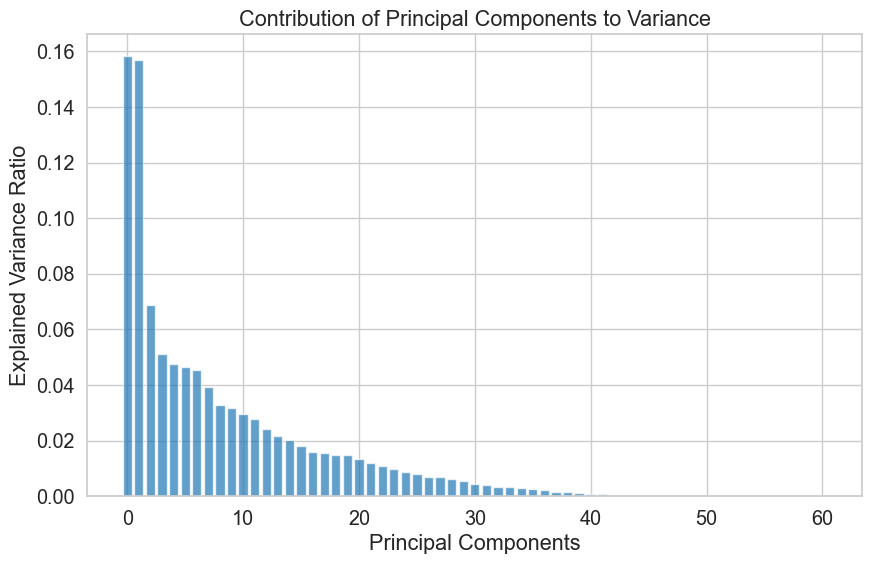

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train_data_without_target = train_data.drop(columns=['monthly_rent'])

# 1. Standardize the data
scaler = StandardScaler()
train_data_standardized = scaler.fit_transform(train_data_without_target)

# 2. Perform PCA
pca = PCA()
pca_result = pca.fit(train_data_standardized)

# 3. Calculate the explained variance ratio for each feature
explained_variance_ratio = pca_result.explained_variance_ratio_
# Calculate the cumulative sum of the explained variance ratio
cumulative_variance = np.cumsum(explained_variance_ratio)
# Find the number of components required to explain at least 90% of the variance
num_components = np.where(cumulative_variance >= 0.90)[0][0] + 1

# Plotting the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio, alpha=0.7, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Contribution of Principal Components to Variance')
plt.show()

In [43]:
# Create a DataFrame to display feature contributions
feature_contributions = pd.DataFrame({
    'Feature': train_data_without_target.columns,
    'Contribution to Variance': explained_variance_ratio
})

print(feature_contributions)

                              Feature  Contribution to Variance
0                           flat_type              1.582476e-01
1                      floor_area_sqm              1.567634e-01
2                     real_estate_age              6.889508e-02
3                           rent_year              5.106989e-02
4                          rent_month              4.759558e-02
5                         index_price              4.659521e-02
6                    index_volatility              4.545592e-02
7              school_median_distance              3.934445e-02
8                 school_std_distance              3.273666e-02
9       school_weighted_mean_distance              3.174154e-02
10           mrt_plan_median_distance              2.958883e-02
11              mrt_plan_std_distance              2.771409e-02
12    mrt_plan_weighted_mean_distance              2.428813e-02
13          mrt_exist_median_distance              2.151922e-02
14             mrt_exist_std_distance   

In [51]:
most_contribute_feature = np.array(feature_contributions['Feature'][:22])
print(most_contribute_feature)

['flat_type' 'floor_area_sqm' 'real_estate_age' 'rent_year' 'rent_month'
 'index_price' 'index_volatility' 'school_median_distance'
 'school_std_distance' 'school_weighted_mean_distance'
 'mrt_plan_median_distance' 'mrt_plan_std_distance'
 'mrt_plan_weighted_mean_distance' 'mrt_exist_median_distance'
 'mrt_exist_std_distance' 'mrt_exist_weighted_mean_distance'
 'mall_median_distance' 'mall_std_distance' 'mall_weighted_mean_distance'
 'school_count' 'mall_count' 'mrt_plan_mrt_adjacent_count']


# 4. Methods - Single Regressors

After EDA and data preprocessing, we can now apply data mining methods for prediction. In this section, we choose different algorithms to generate regression models, including Multiple Linear Regression, Random Forest, XGBoost and LightGBM. The general proposal is to split the preprocessed dataset into train/test data, train and validate with train data, and evaluate the optimized model performance with test data. Finally, compare the models to get a overall picture of how well these regression models perform.

Different modelling methods may involve different data processing and feature engineering techniques. Therefore, instead of using the train_data/test_data directly, we create separate copies of the dataset for each method to generate the corresponding training/testing data for that particular method.

## 4.1 Multiple Linear Regression

In [ ]:
data_mlr = train_data.copy()
data_mlr.columns

For feature selection, we first base on Main Data primarily, and take several attributes 'school_count', 'mall_count', 'mrt_exist_mrt_nearby_count' in the Aux Data to take additional information into consideration.

In [ ]:
X = data_mlr[['flat_type', 'flat_model_0', 'flat_model_1', 'flat_model_2', 'flat_model_3', 'flat_model_4', 'floor_area_sqm', 'latitude', 'longitude', 'planning_area_0', 'planning_area_1', 'planning_area_2',        'planning_area_3', 'planning_area_4', 'real_estate_age', 'rent_month',
       'rent_year', 'school_count', 'mall_count', 'mrt_exist_mrt_nearby_count']]
y = data_mlr['monthly_rent']
X.head()

In [ ]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Standardization on numerical columns
scaler = StandardScaler()
numerical_cols = ['floor_area_sqm', 'latitude', 'longitude', 'real_estate_age', 'school_count', 'mall_count', 'mrt_exist_mrt_nearby_count']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])

### Model Training

In [ ]:
# Instantiate a Linear Regression model, for simplicity here we first take all attributes into consideration
mlr = LinearRegression()
mlr.fit(X_train, y_train)

### Evaluation

#### Evaluate the model on training dataset

We first use metrics to evaluate the model performance on the training dataset.

In [ ]:
y_pred_train = mlr.predict(X_train)

In [ ]:
# Model evaluation metrics
print('R^2:',metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

In [ ]:
# Visualizing
plt.scatter(y_train, y_pred_train)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted")
plt.show()

**Assumptions on MLR Models**

There are some main assumptions on Multiple Regression Models, which are listed below:

* Linearity
* No Multi-Collinearity
* Homoskedasticity
* Independence of independent variable
* Normality
* Independence of errors

We should conduct examinations on whether the assumptions above are satisfied in this context. Basic methods include using diagnostic plots for the relevant analysis. For example, we can use residual plots to check if homoskedasticity is violated or the errors' independency. Also, scatter plots of dependent versus independent variables can help us find non-linear relationships and so on.

* **Linearity**

Linearity in MLR means that the relationship between the independent variables (features) and the dependent variable (target) is linear.

In [ ]:
X_train.columns

In [ ]:
numerical_attributes = ['floor_area_sqm', 'latitude', 'longitude', 'real_estate_age', 'school_count', 'mall_count', 'mrt_exist_mrt_nearby_count']
X_plot = X_train.loc[:,numerical_attributes]
fig, axs = plt.subplots(ncols=7, nrows=1, figsize=(12, 4))

axs = axs.flatten()
for i, k in enumerate(numerical_attributes):
    sns.regplot(y=y_train, x=X_plot[k], ax=axs[i], scatter_kws={"color": "teal"}, line_kws={"color": "red"})
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

We can observe from the plots that the relationship between the independent variables (features) and the dependent variable (target) is linear.

* **No Multi-Collinearity**

Multicollinearity occurs when two or more independent variables in the MLR model are highly correlated, making it difficult to separate their individual effects on the dependent variable. It can impact the reliability of your regression model's coefficients and predictions.

We use the Correlation Matrix to have a look at the multi-collinearity across all variables first. Look for high correlation coefficients (typically greater than 0.7) between pairs of variables. High correlations suggest multicollinearity.

In [ ]:
# Display Correlation Matrix
corrMatrix = X_train.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

`flat_type` and `floor_area_sqm` has a correlation coefficient of 0.95, and `town` and `planning_area` has a correlation coefficient of 0.97. This may suggest multicollinearity.

Note that `flat_type`, `town` and `planning_area` are  encoded and is not numeric values by nature, so we may consider other encoding methods for avoiding multi-collinearity across the variables.

Then we use another metrics Variance Inflation Factor (VIF) to measure how much the variance of the estimated regression coefficients is increased due to multi-collinearity. Calculate the VIF for each independent variable. High VIF values (typically greater than 10) indicate multicollinearity.

In [ ]:
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [ ]:
calc_vif(X_train)

As mentioned above, high VIF values (typically greater than 10) indicate multicollinearity. The form shows features "flat_type", "floor_area_sqm", "real_estate_age", "rent_year", "school_count" and "mall_count" may have issues of multicollinearity, among which the VIF value of "rent_year" is especially high, suggesting the potential inner problem.

* **Homoskedasticity**

Homoscedasticity means that the variance of the residuals (the differences between the observed values and the predicted values) is constant across all levels of the independent variables. If homoscedasticity is violated, it can lead to problems such as biased coefficient estimates and incorrect inference.

In [ ]:
plt.scatter(y_pred_train, y_train - y_pred_train)
plt.title("Residual vs Fit Plot")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

We can observe that there is a random scattering of points with no discernible pattern. As in a homoskedastic dataset, the points should be evenly scattered around the horizontal line at 0 (the residuals have constant variance), we can come to the conclusion that the Homoskedasticity is not violated.

Also, we do not observe a funnel-shaped, fan-shaped pattern, or any other systematic change in the spread of residuals as the fitted values change, which suggests heteroskedasticity (the variance of residuals is not constant).

* **Independence of independent variables**

MLR assumes that independent variables are not perfectly correlated with each other (i.e., they are independent). Violations of this assumption can lead to unstable coefficient estimates and difficulties in interpreting their individual effects. We perform check of the independence, and some typical ones are shown below.

In [ ]:
# Independence of X variables-'floor_area_sqm'
plt.scatter(X_train['floor_area_sqm'], y_train - y_pred_train)
plt.title("Floor Area Size vs Residuals")
plt.xlabel("floor_area_sqm")
plt.ylabel("Residuals")
plt.show()

In [ ]:
# Independence of X variables-'latitude'
plt.scatter(X_train['latitude'], y_train - y_pred_train)
plt.title("Latitude vs Residuals")
plt.xlabel("latitude")
plt.ylabel("Residuals")
plt.show()

In [ ]:
# Independence of X variables-'longitude'
plt.scatter(X_train['longitude'], y_train - y_pred_train)
plt.title("Longitude vs Residuals")
plt.xlabel("latitude")
plt.ylabel("Residuals")
plt.show()

The plots above all show that residuals do appear randomly and symmetrically distributed around zero under all conditions, which prove the independence.

* **Normality**

MLR assumes that the residuals (the differences between the observed and predicted values) are normally distributed. Deviations from normality can impact the validity of statistical inference, such as hypothesis tests and confidence intervals.

In [ ]:
# Normality of residuals
sns.distplot(y_train - y_pred_train)
plt.title("Normality of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

We can see from the plot above that the residuals are normally distributed, which means the normality assumption is satiefied.

* **Independence of errors**

Independence of errors states that the residuals (the differences between the observed values and the predicted values) should be independent of each other. Violations of this assumption can lead to incorrect parameter estimates, unreliable hypothesis tests, and inaccurate predictions.

Here we use *Durbin-Watson Test* for checking independence of errors. This statistical test checks for the presence of autocorrelation in the residuals. A Durbin-Watson statistic value close to 2 indicates no autocorrelation.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson_statistic = durbin_watson(y_train - y_pred_train)
print(f'Durbin-Watson Statistic: {durbin_watson_statistic}')

The Durbin-Watson statistic value is close to 2, which means there is no autocorrelation (i.e. the assmuption is satisfied).

#### Evaluate the model on test dataset

After the evalution on the training dataset, as well as the checks for MLR assmuptions and corresponding model refinement, we can use the model as the final  MLR model and evaluate its performance on the test dataset.

In [ ]:
y_pred_test = mlr.predict(X_test)

In [ ]:
mlr_dict = {'Model':'Multiple Linear Regression',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

mlr_metrics = pd.DataFrame.from_dict(mlr_dict, orient = 'index').T

# Display model performance metrics
mlr_metrics

### Analysis

By looking at the training and testing result of the multiple linear regression model, we could find that the R^2 and RMSE is not very ideal. This might due to we use a very intuitive selection of features, and the simple structure of linear regression model could not handle the complexity of such multiple dimensions. Also we have noticed that there are inner problems of the multiple linear regression model such as the multi-collinearity, which suggests a single MLR model is not an potimal choice in the current context. But still we could base on this model to provide insights on other models, for example the selection of the input features.

</br>

## 4.2 Random Forest

In [ ]:
data_rf = train_data.copy()

In [ ]:
X = data_rf.drop(['monthly_rent'], axis = 1)
y = data_rf['monthly_rent']

In [ ]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Model Training

We use GridSearchCV as a technique to systematically search through different combinations of hyperparameters to find the best set of hyperparameters for RF model.

In [ ]:
rf_param_grid = {
    # 'max_depth': [90, 100], # Maximum number of levels in each decision tree
    'max_depth': [80, 90, 100],
    'max_features': [2, 3], # Maximum number of features considered for splitting a node
    # 'min_samples_leaf': [1, 3], # Minimum number of data points allowed in a leaf node
    'min_samples_leaf': [1, 3, 4, 5],
    # 'n_estimators': [300, 600] # Number of trees in the forest
    'n_estimators': [100, 300, 600]
}

In [ ]:
rf_reg = RandomForestRegressor(random_state = 42)
rf_grid = GridSearchCV(estimator = rf_reg, param_grid = rf_param_grid, cv=5, n_jobs=-1, verbose=2)

In [ ]:
rf_grid.best_params_

In [ ]:
# Get best RF estimator based on best parameters gemerated from above
rf = rf_grid.best_estimator_

### Evaluation

#### Evaluate the model on training dataset

We first use metrics to evaluate the model performance on the training dataset.

In [ ]:
# Use RF regressor to predict on training set
y_pred_train = rf.predict(X_train)

In [ ]:
# Model evaluation metrics
print('R^2:',metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

#### Evaluate the model on testing dataset

In [ ]:
y_pred_test = rf.predict(X_test)

In [ ]:
rf_dict = {'Model':'Random Forest Regressor',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

rf_metrics = pd.DataFrame.from_dict(rf_dict, orient = 'index').T

# Display model performance metrics
rf_metrics

### Analysis

* **Importance of the features**

In [ ]:
rf.feature_importances_

In [ ]:
rf_features = pd.DataFrame([X_train.columns, rf.feature_importances_]).T
rf_features = rf_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
rf_features.sort_values(by = 'Importance Score', ascending = False)

</br>

## 4.3 XGBoost Regressor

In [ ]:
data_xgb = train_data.copy()

In [ ]:
X = data_xgb.drop(['monthly_rent'], axis = 1)
y = data_xgb['monthly_rent']

In [ ]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Model Training

In [ ]:
import xgboost as xgb
from xgboost import plot_importance

In [ ]:
xgb_param_grid = {"learning_rate": [0.05, 0.1, 0.2], # Step size shrinkage used in update to prevents overfitting.
                  "max_depth"        : [6, 8, 9, 10], # Maximum depth of a tree.
                  "min_child_weight" : [1, 3, 5, 7], # Minimum number of instances required in a child node
                  "gamma"            : [0.0, 0.1, 0.2, 0.3], # Minimum loss reduction required to make a further partition on a leaf node of the tree.
                  "colsample_bytree" : [0.3, 0.4, 0.6, 0.8] # Number of features supplied to a tree
}

In [ ]:
xgb_reg = xgb.XGBRegressor(seed = 42, objective ='reg:squarederror')
xgb_grid = GridSearchCV(estimator = xgb_reg, param_grid = xgb_param_grid, cv=5, n_jobs=-1, verbose=2)

In [ ]:
xgb_grid.fit(X_train, y_train)

In [ ]:
xgb_grid.best_params_

In [ ]:
# Get best XGBoost estimator based on best parameters gemerated from above
xgb = xgb_grid.best_estimator_

### Evaluation

#### Evaluate the model on training dataset

We first use metrics to evaluate the model performance on the training dataset.

In [ ]:
# Use XGBoost regressor to predict on training set
y_pred_train = xgb.predict(X_train)

In [ ]:
# Model evaluation metrics
print('R^2:',metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

#### Evaluate the model on testing dataset

In [ ]:
y_pred_test = xgb.predict(X_test)

In [ ]:
xgb_dict = {'Model':'XGBoost Regressor',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

xgb_metrics = pd.DataFrame.from_dict(xgb_dict, orient = 'index').T

# Display model performance metrics
xgb_metrics

### Analysis

* **Importance of the features**

In [ ]:
xgb_features = pd.DataFrame([X_train.columns, xgb.feature_importances_]).T
xgb_features = xgb_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
xgb_features.sort_values(by = 'Importance Score', ascending = False).head(15)

In [ ]:
plot_importance(xgb, max_num_features = 10)

</br>

### 4.4 Model Comparison

In [ ]:
df_metrics = pd.concat([mlr_metrics])
df_metrics.sort_values(by = 'RMSE', ascending = True)

See from the metrics comparison above, XXXXXXX achieves the best performance on the test set with an RMSE of XXXXXXX.

# 5. Method - Ensemble Models

5.1 Baseline

In [ ]:
# *******************Linear model*******************
def get_model():
    net = nn.Sequential(nn.Linear(in_features, 64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.ReLU(),
                        nn.Linear(32, 1),)
    return net

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Adam optimization
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_model()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_model()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
    test_data['Predicted'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([df_id['Id'], test_data['Predicted']], axis=1)
    return submission, train_ls

In [ ]:
# train_data.reset_index(drop=True, inplace=True)
# train_data.head()

In [ ]:
train_len = train_data.shape[0] * 0.8
numeric_attributes=['flat_type', 'floor_area_sqm', 'latitude', 'longitude']
train_data_linear = train_data.loc[:train_len-1,numeric_attributes]
train_data_rent = train_data.loc[:train_len-1,['monthly_rent']]
train_data_rent.shape

In [ ]:
test_data_linear = train_data.loc[train_len:,numeric_attributes]
test_data_linear.head()
print(train_data_linear.shape, test_data_linear.shape)

In [ ]:
train_attributes = torch.tensor(train_data_linear.values, dtype=torch.float32)
test_attributes = torch.tensor(test_data_linear.values, dtype=torch.float32)
train_labels_linear = torch.tensor(train_data_rent.values.reshape(-1, 1), dtype=torch.float32)
loss = nn.MSELoss()
in_features = train_attributes.shape[1]

In [ ]:
# train linear model
k, num_epochs, lr, weight_decay, batch_size = 5, 600, 0.01, 0, 64 # adjust hyperparameter
train_l, valid_l = k_fold(k, train_attributes, train_labels_linear, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold cross-validation: average train log rmse: {float(train_l):f}, '
      f'average test log rmse: {float(valid_l):f}')

In [ ]:
# predict linear model
submission, train_ls = train_and_pred(train_attributes, test_attributes, train_labels_linear, test_data,
               num_epochs, lr, weight_decay, batch_size)
# score = self_evaluation(submission)


In [ ]:
submission.to_csv('result/submission_linear_rmsle'+str(float(train_ls[-1]))[:6]+'.csv', index=False)

In [ ]:
# Define error metrics
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# k-fold Cross Validation
# set verbose=3 for more details
def rmsle_cross_val(X_train, y_train, n_folds, model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return rmse

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

5.1(2) Self-Defined Linear NN Model

In [ ]:
# Define the neural network model
class LinearModel(nn.Module):
    def __init__(self, in_features):
        super(LinearModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# RMSE loss function
def log_rmse(preds, labels):
    clipped_preds = torch.clamp(preds, 1, float('inf'))
    return torch.sqrt(nn.MSELoss()(torch.log(clipped_preds), torch.log(labels)))

# Training function
def train_model(model, train_loader, optimizer, loss_fn):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate_model(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in data_loader:
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Load data
train_data.reset_index(drop=True, inplace=True)
train_len = int(train_data.shape[0] * 0.8)
numeric_attributes = ['flat_type', 'floor_area_sqm', 'latitude', 'longitude']

train_features = torch.tensor(train_data.iloc[:train_len][numeric_attributes].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.iloc[:train_len]['monthly_rent'].values.reshape(-1, 1), dtype=torch.float32)
test_features = torch.tensor(train_data.iloc[train_len:][numeric_attributes].values, dtype=torch.float32)

dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model, optimizer, and loss
model = LinearModel(train_features.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training and evaluation
num_epochs = 600
for epoch in range(num_epochs):
    train_model(model, train_loader, optimizer, loss_fn)
    train_loss = evaluate_model(model, train_loader, log_rmse)
    if epoch % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

# Predictions
model.eval()
with torch.no_grad():
    predictions = model(test_features)

# Create submission dataframe
submission = pd.DataFrame({
    'Id': range(len(predictions)),
    'Predicted': predictions.squeeze().numpy()
})

submission.to_csv('result/submission_linear_rmsle'+str(float(train_ls[-1]))[:6]+'.csv', index=False)

5.2 Lasso Model

In [ ]:
# *******************Lasso model*******************
# lasso_alphas = [0.00001, 0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
# model_lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1000,alphas =lasso_alphas, random_state=42, cv=kfolds))
# model_lasso = make_pipeline(RobustScaler(), Lasso(max_iter=1000, alpha =0.00005, random_state=42))
model_lasso = Lasso(max_iter=1000, alpha =0.00005, tol=0.1, random_state=42)
score_lasso = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))
model_lasso.fit(train_data_linear.values, train_data_rent.values)
model_lasso_pred = model_lasso.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_lasso_pred), columns = ['Predicted'])
model_lasso_pred, df_pred['Predicted']
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_lasso_rmse'+str(float(score_lasso.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************ENet model*******************
# enet_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
# enet_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
model_ENet = make_pipeline(RobustScaler(), ElasticNet(max_iter=3000, alpha=0.0005, l1_ratio=0.8, tol=0.2, random_state=42))
score_ENet = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score_ENet.mean(), score_ENet.std()))
model_ENet.fit(train_data_linear.values, train_data_rent.values)
model_ENet_pred = model_ENet.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_ENet_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_enet_rmse'+str(float(score_ENet.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************Ridge model*******************
ridge_alphas = [1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
model_ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kfolds))
# model_ridge = make_pipeline(RobustScaler(), Ridge(max_iter=1000, alpha=0.1))
score_ridge = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score_ridge.mean(), score_ridge.std()))
model_ridge.fit(train_data_linear.values, train_data_rent.values)
model_ridge_pred = model_ENet.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_ridge_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_ridge_rmse'+str(float(score_ridge.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************SVR model*******************
# C = [0.1, 0.5, 1, 50, 100, 1000]
# epsilon = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
# C:5 - 0.1163 (0.0032), C:10 - 0.1140 (0.0034), epsilon: 0.05 - 0.1105 (0.0039)
model_svr = make_pipeline(RobustScaler(), SVR(C=10, epsilon=0.05, gamma='scale'))
score_svr = rmsle_cross_val(train_data_linear, np.log(train_data_rent), 5, model_svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score_svr.mean(), score_svr.std()))

model_svr.fit(train_data_linear.values, np.log(train_data_rent.values))
model_svr_pred = model_svr.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(np.exp(model_svr_pred)), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_svr_rmsle'+str(float(score_svr.mean()))[:7]+'.csv', index=False)

In [ ]:
test_data.head()

In [ ]:
train_data.head()

In [ ]:
# init train data and test data for non-linear model
all_data_ensemble = train_data.copy()
# test_data_linear = train_data.loc[train_len*0.8:,numeric_attributes]
train_data_ensemble = train_data.copy().drop(columns = ['monthly_rent'])
# test_data_ensemble = test_data.copy().drop(columns = ['Predicted'])
test_data_ensemble = test_data.copy()
train_data_rent = train_data.loc[:train_len/0.8,['monthly_rent']]
train_data_ensemble.shape, test_data_ensemble.shape

In [ ]:
train_data_ensemble.head()

In [ ]:
train_data_rent.head()

In [ ]:
# *******************Random Forest model*******************
# use grid search to produce a baseline rf model
model_rf = RandomForestRegressor(oob_score=True, random_state=3, n_jobs=-1)
params ={
    'n_estimators': [1300],# [800, 900, 1000, 1200, 1500],
    'min_samples_leaf': [1],# [1, 2, 3, 5, 10, 25],
    'max_features': [0.5],# [None, 0.5, 'sqrt', 'log2'],
    'max_depth': [35],# [5, 6, 7, 8, 10, 15, 20],
    'min_samples_split': [2]# [2, 3, 4]
}

best_score = 0
for g in ParameterGrid(params):
    model_rf.set_params(**g)
    model_rf.fit(train_data_ensemble, train_data_rent)
    if model_rf.oob_score_ > best_score:
        best_score = model_rf.oob_score_
        best_grid = g
        print('oob:', best_score, best_grid)
# oob: 0.9764868974915827 {'max_depth': 35, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1300}

In [ ]:
# check feature importance
def RF_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(train_data_ensemble, train_data_rent)
feature_imp = RF_importance(model_rf, train_data_ensemble)
print(model_rf.oob_score_)
print(feature_imp)

In [ ]:
# feature selection
Threshold = 0.0009
to_keep = feature_imp[feature_imp.imp>Threshold].cols
to_keep = [col for _, col in to_keep.items()]
print(to_keep)
df_keep = train_data_ensemble[to_keep].copy()
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(df_keep, train_data_rent)
score_rf = rmsle_cross_val(train_data_ensemble, train_data_rent, 5, model_rf)
print(model_rf.oob_score_, score_rf.mean())

In [ ]:
# deep selection
# keep_cols imp >= 0.01
keep_cols = ['rent_approval_date', 'latitude', 'longitude', 'floor_area_sqm', 'flat_type', 'lease_commence_date', 'flat_model', 'planning_area', 'town', 'region']
cols = to_keep
scores = []
feats = []
for col in cols:
    tmp = to_keep.copy()
    if col in keep_cols:
        continue
    tmp.remove(col)
    df_tmp = train_data_ensemble[tmp].copy()
    model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
    model_rf.fit(df_tmp, train_data_rent)
    scores.append(model_rf.oob_score_)
    feats.append(col)

to_del = sorted(zip(scores, feats), reverse=True)
to_del

In [ ]:
# fine-tuning
# delete increase less than 0.0001
to_keep_final = ['latitude', 'lease_commence_date', 'longitude', 'flat_type', 'flat_model', 'floor_area_sqm',
                 'rent_approval_date']
train_data_final = train_data_ensemble[to_keep_final].copy()
model_rf = RandomForestRegressor(oob_score=True, n_jobs=-1)
params ={
    'n_estimators': [1200, 1250,1280],# [1200, 1250, 1280, 1300, 1350, 1400],
    'min_samples_leaf': [1],# [1, 2, 3, 5, 10, 25],
    'max_features': [0.5],# [0.5, 'sqrt', 'log2'],
    'max_depth': [35],# [5, 6, 7, 8],
    'min_samples_split': [2]# [2, 3, 4]
}

best_score = 0
for g in ParameterGrid(params):
    model_rf.set_params(**g)
    model_rf.fit(train_data_final, train_data_rent)
    if model_rf.oob_score_ > best_score:
        score_rf = rmsle_cross_val(train_data_final, train_data_rent, 5, model_rf)
        best_score = model_rf.oob_score_
        best_grid = g
        print('best oob:', best_score, best_grid, 'score:', score_rf.mean())

In [ ]:
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1250, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(train_data_final, train_data_rent)

In [ ]:
test_data_final = test_data_ensemble[to_keep_final]
# print(test_data_final)
model_rf_pred=model_rf.predict(test_data_final)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_rf_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_rf_'+str(best_score)[:7]+'.csv', index=False)

In [ ]:
# *******************GBoost model*******************
model_GBoost = GradientBoostingRegressor(n_estimators=7000, learning_rate=0.1,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =42)
score_GBoost = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_GBoost)
print("GradientBoostingRegressor score: {:.4f} ({:.4f})\n".format(score_GBoost.mean(), score_GBoost.std()))

model_GBoost.fit(train_data_ensemble.values, train_data_rent.values)
model_gb_pred = model_GBoost.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_gb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_gb_rmsle'+str(float(score_GBoost.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************XGB model*******************
# xgb_params = dict(
#     max_depth=6,           # maximum depth of each tree - try 2 to 10
#     learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
#     n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
#     num_parallel_tree=1,   # set > 1 for boosted random forests
# )
model_xgb = xgb.XGBRegressor(learning_rate=0.01, gamma=0,
                             max_depth=5, min_child_weight = 1,
                             n_estimators=6000, colsample_bytree=0.6,
                             reg_alpha=0.5, reg_lambda=1.0,
                             subsample=0.7, random_state = 42, nthread = -1)
score_xgb = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_xgb)
print("XGB score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))

model_xgb.fit(train_data_ensemble.values, train_data_rent.values)
model_xgb_pred = model_xgb.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_xgb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_xgb_rmsle'+str(float(score_xgb.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************LightGBM model*******************
# Use large max_bin (may be slower)
# Use small learning_rate with large num_iterations
# Use large num_leaves (may cause over-fitting)
model_lgb = lgb.LGBMRegressor(objective='regression',
                       num_leaves=25, learning_rate=0.05,
                       max_bin = 200, n_estimators=1000,
                       random_state=42)
score_lgb = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_lgb)
print("LGB score: {:.4f} ({:.4f})\n".format(score_lgb.mean(), score_lgb.std()))

model_lgb.fit(train_data_ensemble.values, train_data_rent.values)
model_lgb_pred = model_lgb.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_lgb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_lgb_rmsle'+str(float(score_lgb.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************RF model*******************
model_RF = RandomForestRegressor(n_jobs=-1, n_estimators=1250, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_RF.fit(train_data_ensemble.values, train_data_rent.values)

In [ ]:
# *******************Stacking model*******************
model_stack = StackingCVRegressor(regressors=(model_GBoost, model_xgb, model_lgb),
                                meta_regressor=model_rf,
                                use_features_in_secondary=True)
score_stack = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_stack)
print("Stacked score: {:.4f} ({:.4f})\n".format(score_stack.mean(), score_stack.std()))
# fitting stacked model
model_stack.fit(train_data_ensemble.values, train_data_rent.values)
model_stack_pred = model_stack.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_stack_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('/submission_stacked_rmsle'+str(float(score_stack.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************Blend models/Weighting*******************
def blended_predictions(X):
    return ((0.05 * model_GBoost.predict(X)) + \
            (0.1 * model_xgb.predict(X)) + \
            (0.1 * model_lgb.predict(X)) + \
            (0.55 * model_RF.predict(X)) + \
            (0.2 * model_stack.predict(X)))

model_blend_pred = blended_predictions(train_data_ensemble.values)
score_blend = rmse(np.log(train_data_rent.values), np.log(model_blend_pred))
print(score_blend)

In [ ]:
model_blended_pred = blended_predictions(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_blended_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_blended_rmsle'+str(score_blend)[:7]+'.csv', index=False)